# To The Space and Beyond

In [1]:
import os
import joblib
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor, MLPClassifier

from IPython.display import clear_output, HTML
from gymnasium.wrappers.record_video import RecordVideo
from pathlib import Path

GAME = 'LunarLander-v2'

Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)


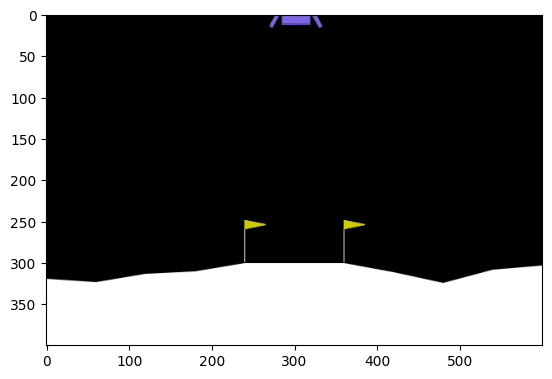

In [2]:
env = gym.make(GAME, render_mode="rgb_array", continuous=True)

env.reset()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

plt.imshow(env.render())

env.close()

In [3]:
def generate_session(env: gym.Env, agent: MLPRegressor | MLPClassifier, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for _ in range(t_max):

        if isinstance(agent, MLPRegressor):
            a = agent.predict([s])[0]
        elif isinstance(agent, MLPClassifier):
            a = np.random.choice(range(env.action_space.n), p=agent.predict_proba([s])[0]) 
        else:
            raise ValueError("agent must be MLPRegressor or MLPClassifier")

        new_s, r, terminated, truncated, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r # type: ignore    

        s = new_s
        if terminated or truncated:
            break
    else:
        print("Game was not finished")
        
    return states, actions, total_reward


In [4]:

def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [s for i, game in enumerate(states_batch) if rewards_batch[i] > reward_threshold for s in game]
    elite_actions = [a for i, game in enumerate(actions_batch) if rewards_batch[i] > reward_threshold for a in game]

    return elite_states, elite_actions


In [5]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()

    plt.show()


In [6]:
choice = int(input())

if choice == 1:
    env = gym.make(GAME, render_mode="rgb_array", continuous=True)
    agent = MLPRegressor(hidden_layer_sizes=(64, 64), activation='tanh', solver='adam', learning_rate_init=0.003)

    agent.partial_fit([env.reset()[0]], [env.action_space.sample()])
else:
    env = gym.make(GAME, render_mode="rgb_array", continuous=False)
    agent = MLPClassifier(hidden_layer_sizes=(64, 64), activation='tanh', solver='adam', learning_rate_init=0.001)
    
    agent.partial_fit([env.reset()[0]], [env.action_space.sample()], classes=range(env.action_space.n))


mean reward = 144.421, threshold=237.203


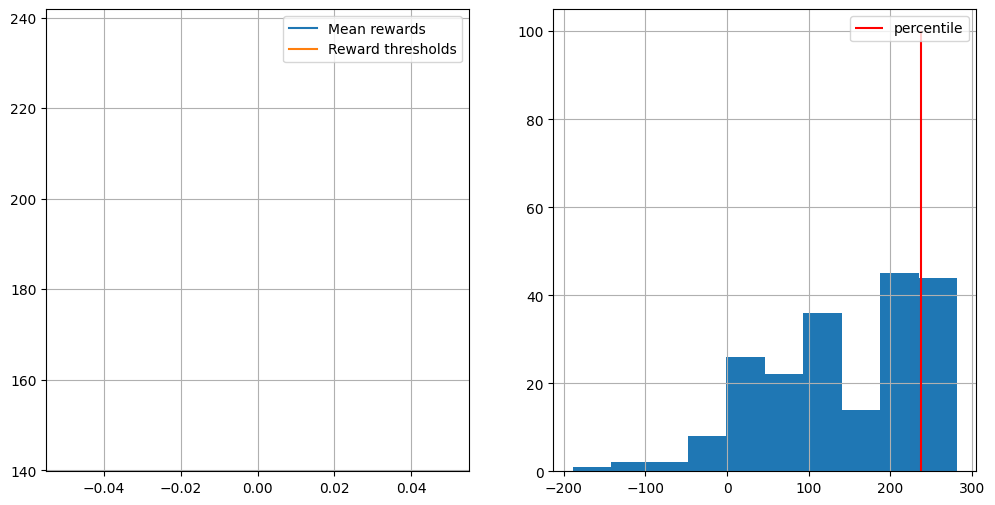

Yay, dats gud enuf for mai boi
Training interrupted


In [7]:
n_sessions = 200
percentile = 80
log = []

try:
    for i in range(100):
        sessions = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
                (joblib.delayed(generate_session)(env, agent, 10**5) for _ in range(n_sessions))
    
        states_batch, actions_batch, rewards_batch = zip(*sessions)
    
        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
        agent.partial_fit(elite_states, elite_actions)
    
        show_progress(
            rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)]
        )
    
        if np.mean(rewards_batch) > 50:
            print("Yay, dats gud enuf for mai boi")
        if np.mean(rewards_batch) > 200:
            print("Now we're a pro")
            
except KeyboardInterrupt:
    print("Training interrupted")

In [ ]:
os.makedirs('models', exist_ok=True)
joblib.dump(agent, 'models/LunarLander-v2-agent-noncontinuous.joblib')

In [ ]:
with RecordVideo(
    env=gym.make(GAME, render_mode="rgb_array"),
    video_folder=f"./videos/{GAME}",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent, t_max=10**8) for _ in range(5)]

In [157]:
video_paths = sorted([s for s in Path(f"videos/{GAME}").iterdir() if s.suffix == ".mp4"])
video_path = np.random.choice(video_paths) # type: ignore

data_url = str(video_path)

HTML(
    f"""
<video width="640" height="480" controls>
  <source src="{data_url}" type="video/mp4">
</video>""" 
)

In [ ]:
from gymnasium.utils import play
play.play(gym.make(GAME, render_mode='rgb_array'), zoom=3, keys_to_action={'w': 3, 'e': 2, 'r': 1})